# Time Series Analysis with Facebook Prophet
## Additive Models for Time Series Modeling

<img src=http://www.yankodesign.com/images/design_news/2015/03/18/pinclock_04.jpg /> <img src=http://uploads.neatorama.com/images/posts/307/64/64307/1376759653-0.jpg />

Time series are one of the most common data types encountered in daily life. Financial prices, weather, home energy usage, and even weight are all examples of data that can be collected at regular intervals. Almost every data scientist will encounter time series in their daily work and learning how to model them is an important skill in the data science toolbox. One powerful yet simple method for analyzing and predicting periodic data is the additive model. The idea is straightforward: represent a time-series as a combination of patterns at different scales such as daily, weekly, seasonally, and yearly, along with an overall trend. Your energy use might rise in the summer and decrease in the winter, but have an overall decreasing trend as you increase the energy efficiency of your home. An additive model can show us both patterns/trends and make predictions based on these observations.

The following image shows an additive model decomposition of a time-series into an overall trend, yearly trend, and weekly trend.

<img src=https://cdn-images-1.medium.com/max/1000/1*p5l_eKG4we5d8GDzC6o_gg.png />



This Jupyter Notebook will walk through an introductory example of creating an additive model for time-series data regarding ride sharing price estimates using Python and the Prophet forecasting package developed by Facebook. Along the way, we will cover some data manipulation using pandas and plotting with matplotlib. This introduction will show you all the steps needed to start modeling time-series on your own!

### Retrieving the Data

Usually, about 80% of the time spent on a data science project is getting and cleaning data. But thankfully for you readers the data we need is up on __[Mandy Yang's GitHub](https://github.com/MandyYang86/Ride-Optimization/tree/master/Merge%20Data)__.

First, we import the required libraries and read the data with pandas' read_csv function.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
%matplotlib inline

The pandas dataframe is formed and it is the data structure of __*CHOICE*__ for data science.

In [27]:
df1 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/uber_pool_March.csv')
df2 = pd.read_csv('https://raw.githubusercontent.com/MandyYang86/Ride-Optimization/master/Merge%20Data/lyft_line_March.csv')

Here with the .head function of pandas we can look at the first first rows of uberPOOL's data in March. The explanation of each column headings is available in README.md file.

In [28]:
df1.head()

,Unnamed: 0,date_time,date,day,uber_display_name,uber_distance,uber_duration,end_latitude,end_location,end_longitude,...,main_temp,main_temp_max,main_temp_min,uber_product_id,start_latitude,start_location,start_longitude,time,weather,uber_category
0,0,2/25/2018 0:00,25-Feb-18,Sunday,POOL,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,...,39.52,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.361652,Urban AdvenTours,-71.052037,0:00:04,Clear,Carpool Service
1,6,2/25/2018 0:01,25-Feb-18,Sunday,POOL,1.50,420,42.355373,Boston Common,-71.065750,...,39.52,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.347060,Kings Dining & Entertainment - Boston Back Bay,-71.085650,0:01:03,Clear,Carpool Service
2,12,2/25/2018 0:02,25-Feb-18,Sunday,POOL,1.45,360,42.363520,Innercity Weightlifting,-71.082860,...,39.47,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.377843,Achieve Fitness,-71.091881,0:02:03,Clear,Carpool Service
3,18,2/25/2018 0:03,25-Feb-18,Sunday,POOL,2.26,540,42.370460,Broadway Bicycle School,-71.103520,...,39.79,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.348503,Commonwealth Avenue Mall,-71.094223,0:03:04,Clear,Carpool Service
4,24,2/25/2018 0:04,25-Feb-18,Sunday,POOL,2.47,540,42.352040,Btone Fitness - Back Bay,-71.072590,...,38.95,44.6,33.8,997acbb5-e102-41e1-b155-9df7de0a73f2,42.365095,Prana Power Yoga,-71.102730,0:04:03,Clear,Carpool Service


In [30]:
df1.columns

Index(['date_time', 'date', 'day', 'uber_display_name', 'uber_distance',
       'uber_duration', 'end_latitude', 'end_location', 'end_longitude',
       'uber_max_estimate', 'uber_min_estimate', 'main_temp', 'main_temp_max',
       'main_temp_min', 'uber_product_id', 'start_latitude', 'start_location',
       'start_longitude', 'time', 'weather', 'uber_category'],
      dtype='object')

In [31]:
df2.head()

,date_time,lyft_display_name,lyft_max_estimate,lyft_min_estimate,lyft_distance,lyft_duration,lyft_category
0,2/25/2018 0:00,Lyft Line,352,352,3.10,745,Carpool Service
1,2/25/2018 0:01,Lyft Line,308,308,1.82,589,Carpool Service
2,2/25/2018 0:02,Lyft Line,428,428,1.61,422,Carpool Service
3,2/25/2018 0:03,Lyft Line,335,335,2.65,690,Carpool Service
4,2/25/2018 0:04,Lyft Line,589,589,2.66,767,Carpool Service


In [32]:
df1 = df1.set_index(pd.DatetimeIndex(df1['date_time']))
df2 = df2.set_index(pd.DatetimeIndex(df1['date_time']))

In [33]:
df2.lyft_max_estimate = (df2.lyft_max_estimate).divide(100)
df2.lyft_min_estimate = (df2.lyft_min_estimate).divide(100)

In [37]:
df1['uber_max_estimate']
df1['uber_min_estimate']

date_time
2018-02-25 00:00:00     9
2018-02-25 00:01:00     6
2018-02-25 00:02:00     6
2018-02-25 00:03:00     8
2018-02-25 00:04:00     8
2018-02-25 00:05:00     8
2018-02-25 00:06:00    10
2018-02-25 00:07:00     4
2018-02-25 00:08:00     7
2018-02-25 00:09:00     8
2018-02-25 00:10:00     8
2018-02-25 00:11:00     6
2018-02-25 00:12:00     8
2018-02-25 00:13:00     8
2018-02-25 00:14:00     8
2018-02-25 00:15:00     8
2018-02-25 00:16:00     7
2018-02-25 00:17:00    10
2018-02-25 00:18:00     7
2018-02-25 00:19:00     9
2018-02-25 00:20:00     9
2018-02-25 00:21:00     5
2018-02-25 00:22:00    10
2018-02-25 00:23:00     7
2018-02-25 00:24:00     7
2018-02-25 00:25:00     5
2018-02-25 00:26:00     5
2018-02-25 00:27:00    10
2018-02-25 00:28:00     7
2018-02-25 00:29:00    11
                       ..
2018-03-03 23:29:00     8
2018-03-03 23:30:00     9
2018-03-03 23:31:00     8
2018-03-03 23:32:00     8
2018-03-03 23:33:00     6
2018-03-03 23:34:00     7
2018-03-03 23:35:00     7
20

In [38]:
df1['uber_price_estimate'] = (df1['uber_max_estimate'] + df1['uber_min_estimate'])/2
df2['lyft_price_estimate'] = (df2['lyft_max_estimate'] + df2['lyft_min_estimate'])/2

In [102]:
df1['uber_price_per_second'] = df1.y/df1.uber_duration
df1['uber_price_per_second']

date_time
2018-02-25 00:00:00    0.020370
2018-02-25 00:01:00    0.019048
2018-02-25 00:02:00    0.020833
2018-02-25 00:03:00    0.018519
2018-02-25 00:04:00    0.018519
2018-02-25 00:05:00    0.020833
2018-02-25 00:06:00    0.018182
2018-02-25 00:07:00    0.018333
2018-02-25 00:08:00    0.021429
2018-02-25 00:09:00    0.018519
2018-02-25 00:10:00    0.018519
2018-02-25 00:11:00    0.019048
2018-02-25 00:12:00    0.013889
2018-02-25 00:13:00    0.020833
2018-02-25 00:14:00    0.018519
2018-02-25 00:15:00    0.017593
2018-02-25 00:16:00    0.021429
2018-02-25 00:17:00    0.018182
2018-02-25 00:18:00    0.021429
2018-02-25 00:19:00    0.015278
2018-02-25 00:20:00    0.018333
2018-02-25 00:21:00    0.014583
2018-02-25 00:22:00    0.016667
2018-02-25 00:23:00    0.017708
2018-02-25 00:24:00    0.016667
2018-02-25 00:25:00    0.013542
2018-02-25 00:26:00    0.016667
2018-02-25 00:27:00    0.025000
2018-02-25 00:28:00    0.025000
2018-02-25 00:29:00    0.028125
                         ...  

In [103]:
df2['lyft_price_per_second'] = df2.y/df2.lyft_duration
df2['lyft_price_per_second']

date_time
2018-02-25 00:00:00    0.004725
2018-02-25 00:01:00    0.005229
2018-02-25 00:02:00    0.010142
2018-02-25 00:03:00    0.004855
2018-02-25 00:04:00    0.007679
2018-02-25 00:05:00    0.004937
2018-02-25 00:06:00    0.008138
2018-02-25 00:07:00    0.009482
2018-02-25 00:08:00    0.005970
2018-02-25 00:09:00    0.005113
2018-02-25 00:10:00    0.004992
2018-02-25 00:11:00    0.005283
2018-02-25 00:12:00    0.004000
2018-02-25 00:13:00    0.004710
2018-02-25 00:14:00    0.004336
2018-02-25 00:15:00    0.005049
2018-02-25 00:16:00    0.005430
2018-02-25 00:17:00    0.006610
2018-02-25 00:18:00    0.005143
2018-02-25 00:19:00    0.006592
2018-02-25 00:20:00    0.004227
2018-02-25 00:21:00    0.004640
2018-02-25 00:22:00    0.006972
2018-02-25 00:23:00    0.010234
2018-02-25 00:24:00    0.005346
2018-02-25 00:25:00    0.005100
2018-02-25 00:26:00    0.007564
2018-02-25 00:27:00    0.004838
2018-02-25 00:28:00    0.006623
2018-02-25 00:29:00    0.011605
                         ...  

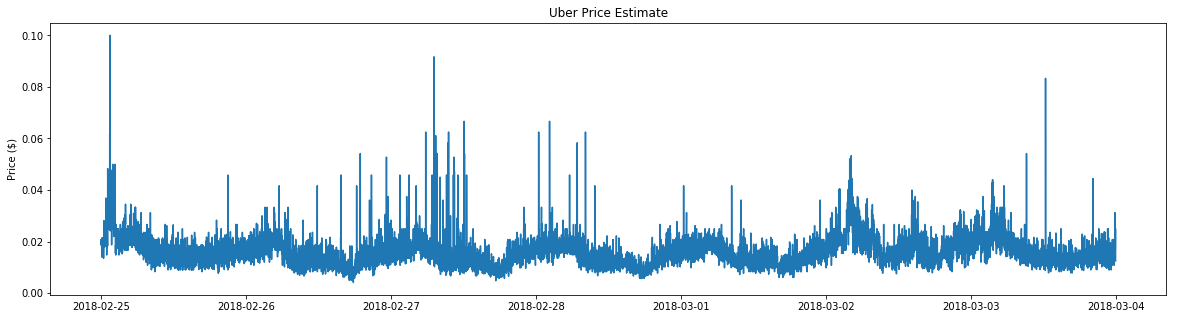

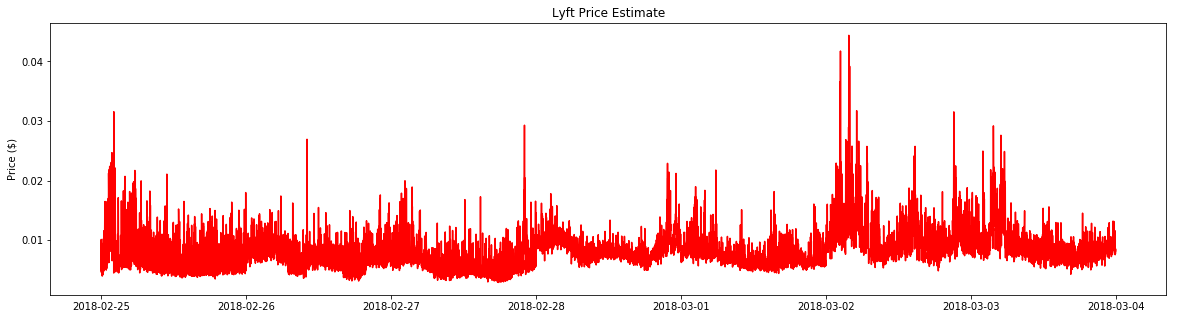

In [105]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.plot(df1.index, df1['uber_price_per_second'])
plt.title('Uber Price Estimate')
plt.ylabel('Price ($)')
plt.show()

plt.plot(df2.index, df2['lyft_price_per_second'], 'r')
plt.title('Lyft Price Estimate')
plt.ylabel('Price ($)')
plt.show()

In [113]:
# Merge the two datasets
df = df1.merge(df2, how='inner', on='ds')

In [114]:
df.head()

,ds,date,day,uber_display_name,uber_distance,uber_duration,end_latitude,end_location,end_longitude,uber_max_estimate,...,lyft_min_estimate,lyft_distance,lyft_duration,lyft_category,y_y,0.001,0.05,0.1,0.5,lyft_price_per_second
0,2/25/2018 0:00,25-Feb-18,Sunday,POOL,2.83,540,42.363046,Charles River Canoe & Kayak,-71.082354,13,...,3.52,3.10,745,Carpool Service,3.52,NaN,NaN,NaN,NaN,0.004725
1,2/25/2018 0:01,25-Feb-18,Sunday,POOL,1.50,420,42.355373,Boston Common,-71.065750,10,...,3.08,1.82,589,Carpool Service,3.08,NaN,NaN,NaN,NaN,0.005229
2,2/25/2018 0:02,25-Feb-18,Sunday,POOL,1.45,360,42.363520,Innercity Weightlifting,-71.082860,9,...,4.28,1.61,422,Carpool Service,4.28,NaN,NaN,NaN,NaN,0.010142
3,2/25/2018 0:03,25-Feb-18,Sunday,POOL,2.26,540,42.370460,Broadway Bicycle School,-71.103520,12,...,3.35,2.65,690,Carpool Service,3.35,NaN,NaN,NaN,NaN,0.004855
4,2/25/2018 0:04,25-Feb-18,Sunday,POOL,2.47,540,42.352040,Btone Fitness - Back Bay,-71.072590,12,...,5.89,2.66,767,Carpool Service,5.89,NaN,NaN,NaN,NaN,0.007679


In [116]:
# Select only the relevant columns
df = df.ix[:, ['ds', 'uber_price_per_second', 'lyft_price_per_second']]

df.head()

C:\Users\Maxx\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


,ds,uber_price_per_second,lyft_price_per_second
0,2/25/2018 0:00,0.020370,0.004725
1,2/25/2018 0:01,0.019048,0.005229
2,2/25/2018 0:02,0.020833,0.010142
3,2/25/2018 0:03,0.018519,0.004855
4,2/25/2018 0:04,0.018519,0.007679


In [118]:
df.ds = pd.to_datetime(df.ds)

In [119]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9980 entries, 0 to 9979
Data columns (total 3 columns):
ds                       9980 non-null datetime64[ns]
uber_price_per_second    9980 non-null float64
lyft_price_per_second    9980 non-null float64
dtypes: datetime64[ns](1), float64(2)
memory usage: 311.9 KB


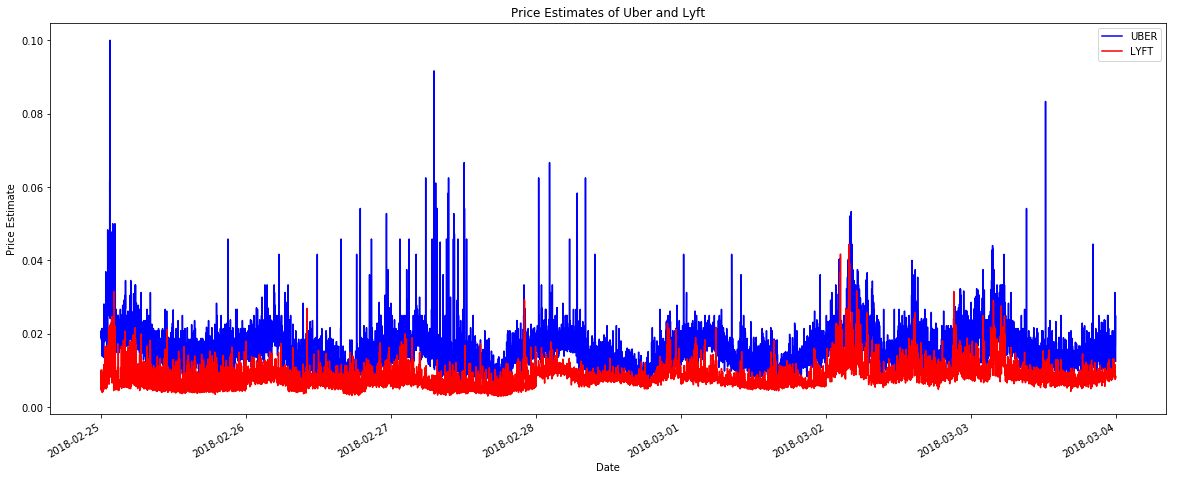

In [121]:
plt.rcParams["figure.figsize"] = (20, 8)
plt.plot(df['ds'], df['uber_price_per_second'], 'b-', label = 'UBER')
plt.plot(df['ds'], df['lyft_price_per_second'], 'r-', label = 'LYFT')
plt.xlabel('Date')
plt.ylabel('Price Estimate')
plt.title('Price Estimates of Uber and Lyft')
plt.gcf().autofmt_xdate()
plt.legend()

In [122]:
# Find the first and last time lyft price estimate was higher than uber
first_date = df.ix[np.min(list(np.where(df['lyft_price_per_second'] > df['uber_price_per_second'])[0])), 'ds']
last_date = df.ix[np.max(list(np.where(df['lyft_price_per_second'] > df['uber_price_per_second'])[0])), 'ds']

print("Lyft's price estimate was higher than Uber from {} to {}.".format(first_date.date(), last_date.date()))

Lyft's price estimate was higher than Uber from 2018-02-25 to 2018-03-03.


C:\Users\Maxx\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  from ipykernel import kernelapp as app


In [139]:
df1 = df[['ds', 'uber_price_per_second']]
df1.head()

,ds,uber_price_per_second
0,2018-02-25 00:00:00,0.020370
1,2018-02-25 00:01:00,0.019048
2,2018-02-25 00:02:00,0.020833
3,2018-02-25 00:03:00,0.018519
4,2018-02-25 00:04:00,0.018519


In [141]:
df2 = df[['ds', 'lyft_price_per_second']]
df2.head()

,ds,lyft_price_per_second
0,2018-02-25 00:00:00,0.004725
1,2018-02-25 00:01:00,0.005229
2,2018-02-25 00:02:00,0.010142
3,2018-02-25 00:03:00,0.004855
4,2018-02-25 00:04:00,0.007679


In [142]:
import fbprophet

# Prophet requires columns ds (Date) and y (value)
df1 = df1.rename(columns={'uber_price_per_second': 'y'})
# Make the prophet models and fit on the data
# changepoint_prior_scale can be changed to achieve a better fit
uber_prophet = fbprophet.Prophet()
uber_prophet.fit(df1)

# Repeat for the lyft data
df2 = df2.rename(columns={'lyft_price_per_second': 'y'})
lyft_prophet = fbprophet.Prophet()
lyft_prophet.fit(df2)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


In [172]:
# Make a future dataframe for 1 day
uber_forecast = uber_prophet.make_future_dataframe(periods=1440, freq='T')
# Make predictions
uber_forecast = uber_prophet.predict(uber_forecast)

lyft_forecast = lyft_prophet.make_future_dataframe(periods=1440, freq='T')
lyft_forecast = lyft_prophet.predict(lyft_forecast)

Text(0.5,1,'UBER Price Estimate')

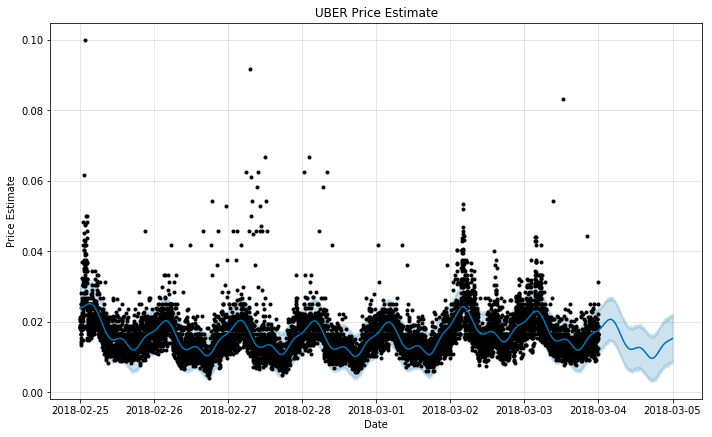

In [173]:
uber_prophet.plot(uber_forecast, xlabel = 'Date', ylabel = 'Price Estimate')
plt.title('UBER Price Estimate')

Text(0.5,1,'LYFT Price Estimate')

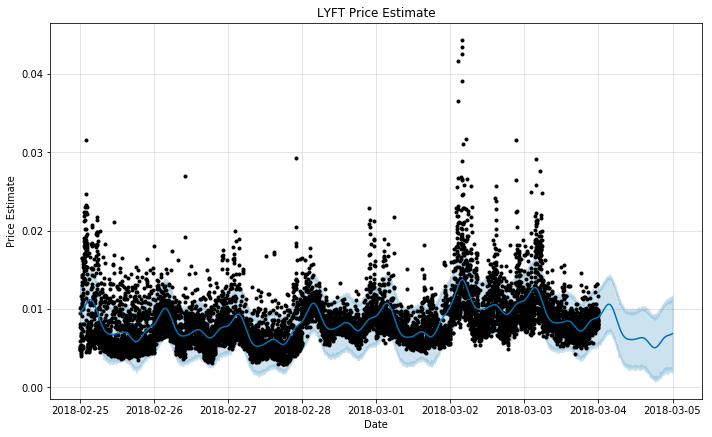

In [174]:
lyft_prophet.plot(lyft_forecast, xlabel = 'Date', ylabel = 'Price Estimate')
plt.title('LYFT Price Estimate')

In [175]:
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    model = fbprophet.Prophet(changepoint_prior_scale=changepoint)
    model.fit(df2)
    
    future = model.make_future_dataframe(periods=1440, freq='T')
    future = model.predict(future)
    
    df2[changepoint] = future['yhat']

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


Text(0.5,1,'Effect of Changepoint Prior Scale')

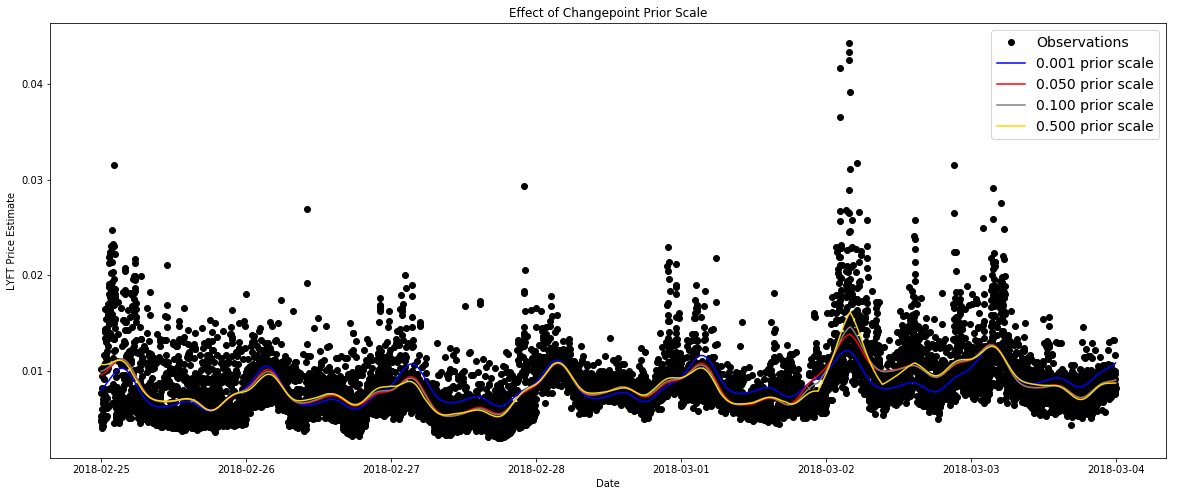

In [176]:
# Create the plot
plt.figure(figsize=(20, 8))

# Actual observations
plt.plot(df2['ds'], df2['y'], 'ko', label = 'Observations')
colors = {0.001: 'b', 0.05: 'r', 0.1: 'grey', 0.5: 'gold'}

# Plot each of the changepoint predictions
for changepoint in [0.001, 0.05, 0.1, 0.5]:
    plt.plot(df2['ds'], df2[changepoint], color = colors[changepoint], label = '%.3f prior scale' % changepoint)
    
plt.legend(prop={'size': 14})
plt.xlabel('Date')
plt.ylabel('LYFT Price Estimate')
plt.title('Effect of Changepoint Prior Scale')

In [177]:
uber_prophet.changepoints[:10]

319    2018-02-25 05:21:00
639    2018-02-25 10:41:00
958    2018-02-25 16:00:00
1277   2018-02-25 21:19:00
1597   2018-02-26 02:39:00
1916   2018-02-26 07:58:00
2236   2018-02-26 13:18:00
2555   2018-02-26 18:41:00
2874   2018-02-27 00:01:00
3194   2018-02-27 05:23:00
Name: ds, dtype: datetime64[ns]

In [178]:
lyft_prophet.changepoints[:10]

319    2018-02-25 05:21:00
639    2018-02-25 10:41:00
958    2018-02-25 16:00:00
1277   2018-02-25 21:19:00
1597   2018-02-26 02:39:00
1916   2018-02-26 07:58:00
2236   2018-02-26 13:18:00
2555   2018-02-26 18:41:00
2874   2018-02-27 00:01:00
3194   2018-02-27 05:23:00
Name: ds, dtype: datetime64[ns]

In [179]:
uber_names = ['uber_%s' % column for column in uber_forecast.columns]
lyft_names = ['lyft_%s' % column for column in lyft_forecast.columns]

# Dataframes to merge
merge_uber_forecast = uber_forecast.copy()
merge_lyft_forecast = lyft_forecast.copy()

# Rename the columns
merge_uber_forecast.columns = uber_names
merge_lyft_forecast.columns = lyft_names

In [180]:
# Merge the two datasets
forecast = pd.merge(merge_uber_forecast, merge_lyft_forecast, how = 'inner', left_on = 'uber_ds', right_on = 'lyft_ds')

# Rename date column
forecast = forecast.rename(columns={'uber_ds': 'Date Time'}).drop('lyft_ds', axis=1)
forecast.head()

,Date Time,uber_trend,uber_trend_lower,uber_trend_upper,uber_yhat_lower,uber_yhat_upper,uber_daily,uber_daily_lower,uber_daily_upper,uber_seasonal,...,lyft_daily,lyft_daily_lower,lyft_daily_upper,lyft_seasonal,lyft_seasonal_lower,lyft_seasonal_upper,lyft_seasonalities,lyft_seasonalities_lower,lyft_seasonalities_upper,lyft_yhat
0,2018-02-25 00:00:00,0.021950,0.021950,0.021950,0.018282,0.030030,0.001945,0.001945,0.001945,0.001945,...,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.000810,0.009532
1,2018-02-25 00:01:00,0.021940,0.021940,0.021940,0.017965,0.029633,0.001957,0.001957,0.001957,0.001957,...,0.000816,0.000816,0.000816,0.000816,0.000816,0.000816,0.000816,0.000816,0.000816,0.009538
2,2018-02-25 00:02:00,0.021929,0.021929,0.021929,0.018548,0.030605,0.001970,0.001970,0.001970,0.001970,...,0.000823,0.000823,0.000823,0.000823,0.000823,0.000823,0.000823,0.000823,0.000823,0.009543
3,2018-02-25 00:03:00,0.021919,0.021919,0.021919,0.018133,0.029830,0.001983,0.001983,0.001983,0.001983,...,0.000830,0.000830,0.000830,0.000830,0.000830,0.000830,0.000830,0.000830,0.000830,0.009548
4,2018-02-25 00:04:00,0.021909,0.021909,0.021909,0.017845,0.030302,0.001996,0.001996,0.001996,0.001996,...,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.000836,0.009554


Text(0.5,1,'UBER vs. LYFT Trend')

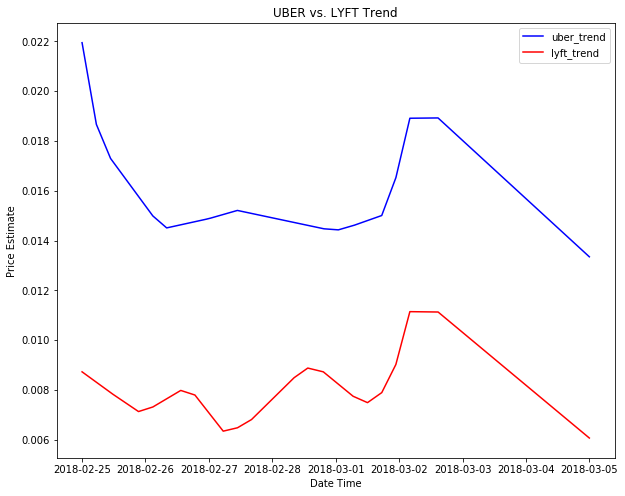

In [181]:
# Visualize Trend Only and the Forecast
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date Time'], forecast['uber_trend'], 'b-')
plt.plot(forecast['Date Time'], forecast['lyft_trend'], 'r-')
plt.legend()
plt.xlabel('Date Time')
plt.ylabel('Price Estimate')
plt.title('UBER vs. LYFT Trend')

Text(0.5,1,'UBER vs. LYFT Estimate')

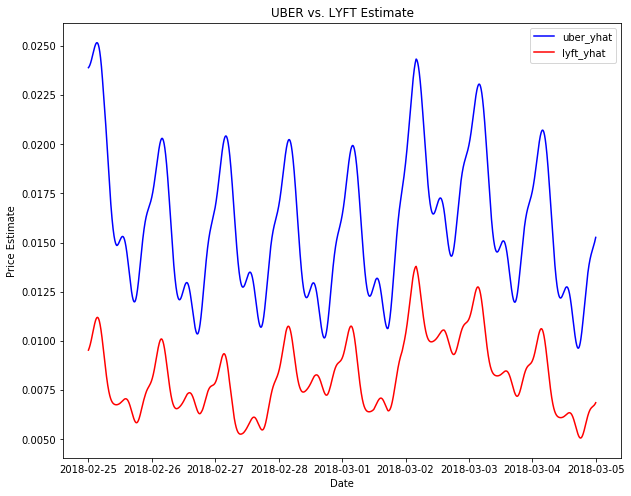

In [182]:
plt.figure(figsize=(10, 8))
plt.plot(forecast['Date Time'], forecast['uber_yhat'], 'b-')
plt.plot(forecast['Date Time'], forecast['lyft_yhat'], 'r-')
plt.legend(); plt.xlabel('Date')
plt.ylabel('Price Estimate')
plt.title('UBER vs. LYFT Estimate')

Text(0.5,1,'Price Prediction for UBER and LYFT')

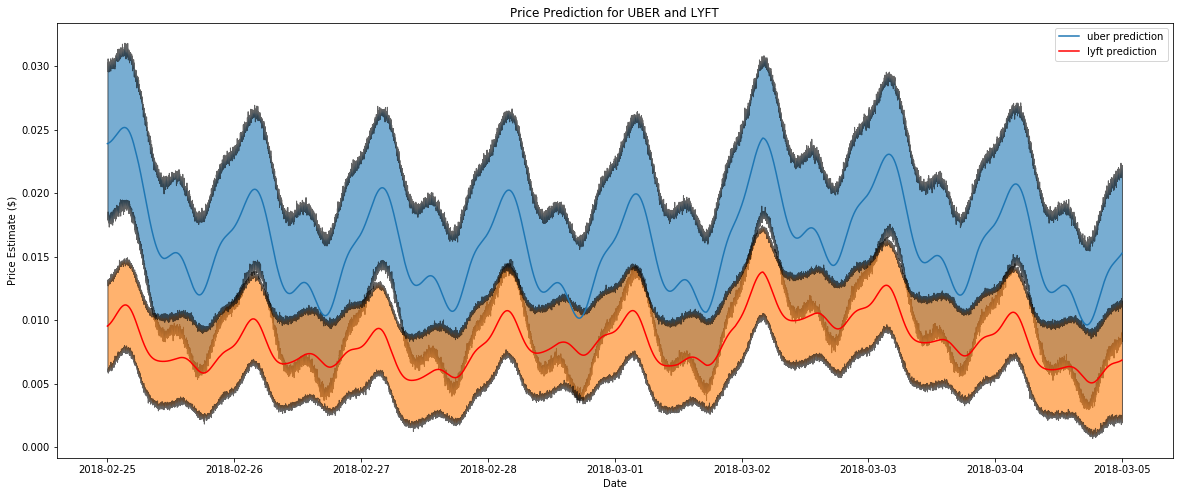

In [183]:
# Create subplots to set figure size
fig, ax = plt.subplots(1, 1, figsize=(20, 8))

# Plot estimate
ax.plot(forecast['Date Time'], forecast['uber_yhat'], label = 'uber prediction')

# Plot uncertainty values
ax.fill_between(forecast['Date Time'].dt.to_pydatetime(), forecast['uber_yhat_upper'], forecast['uber_yhat_lower'], alpha=0.6, edgecolor = 'k')

# Plot estimate and uncertainty for lyft
ax.plot(forecast['Date Time'], forecast['lyft_yhat'], 'r', label = 'lyft prediction')
ax.fill_between(forecast['Date Time'].dt.to_pydatetime(), forecast['lyft_yhat_upper'], forecast['lyft_yhat_lower'], alpha=0.6, edgecolor = 'k')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price Estimate ($)')
plt.title('Price Prediction for UBER and LYFT')

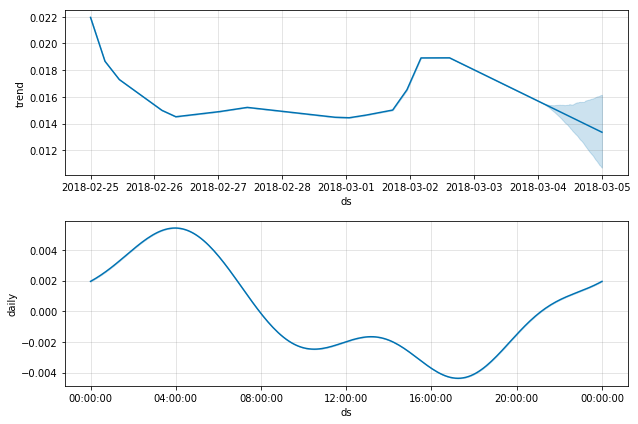

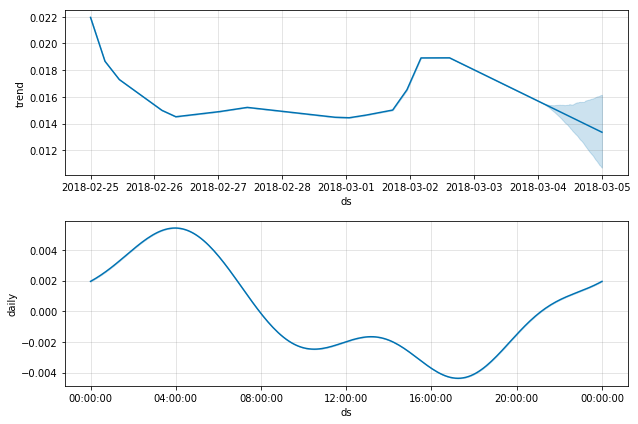

In [184]:
uber_prophet.plot_components(uber_forecast)

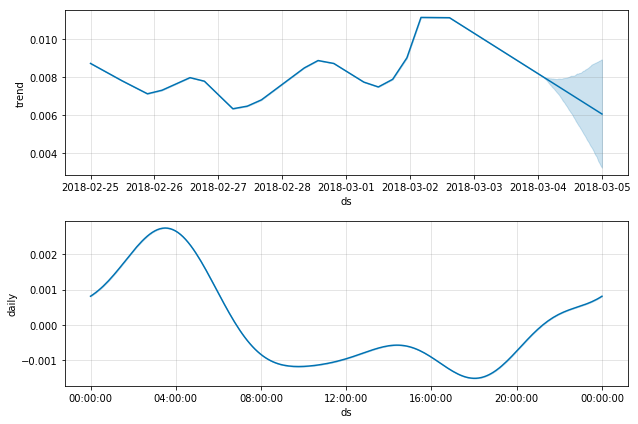

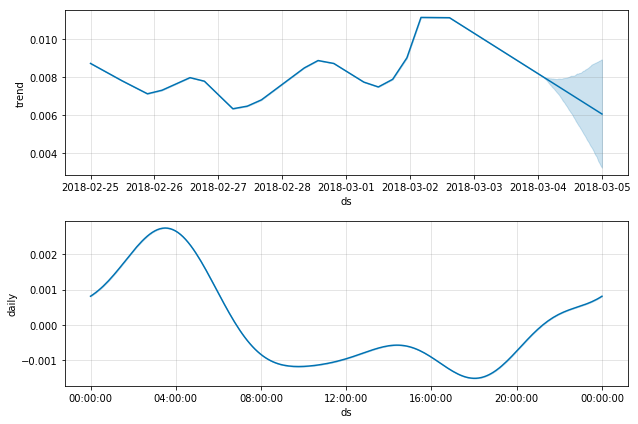

In [185]:
lyft_prophet.plot_components(lyft_forecast)